In [1]:
# import required packages
import seaborn as sns
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC 
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# upload the dataset and load the data.
# this dataset contains the date information for transaction.
file1 = 'Transacation_outflows_with_date_3k_firsthalf.pqt'
data1 = pd.read_parquet(file1, engine='auto')
file2 = 'Transacation_outflows_with_date_3k_secondhalf.pqt'
data2 = pd.read_parquet(file2, engine='auto')

In [3]:
# create a dataframe for the dataset
df = pd.concat([data1, data2], axis=0)

In [4]:
df.loc[79]

prism_consumer_id                                  0
prism_account_id                               acc_0
memo                 39 PIADA CUYAHOGA FALL OH 06/19
amount                                         23.45
posted_date                               2022-06-21
category                          FOOD_AND_BEVERAGES
Name: 79, dtype: object

In [5]:
# Filter the required categories and define a new dataset
# which only contains these categories.
categories_filter = ['GENERAL_MERCHANDISE', 'FOOD_AND_BEVERAGES', 'GROCERIES', 'TRAVEL', 'PETS', 'EDUCATION', 'OVERDRAFT', 'RENT', 'MORTGAGE']
df = df[df['category'].isin(categories_filter)]

In [6]:
len(df)

1306452

In [7]:
# Data Cleanning Process Part


## Changing memo_clean column values to all lower case first.
df['memo'] = df['memo'].str.lower()


## Use regular expressions to remove text after ".com" 
## and keep the preceding text from ".com"
def remove_com(text):
    cleaned_text = re.sub(r'\.com(\/bill|\*).*?(?=\s|$)', '', text)
    return cleaned_text


## Removing useless pattenrs
def remove_key_phrases(text):
    phrases = [
        'pos debit - visa check card xxxx - ',
        r'purchase authorized on \d{2}\/\d{2}',
        'pos purchase',
        'purchase',
        'pos',
        'web id',
        'terminal id',
        r'\b(id)\b',
        'withdrawal consumer debit',
        'withdrawal',
        'debit card',
        'credit card',
        'checkcard',
        'recurring payment authorized on'
    ]
    for phrase in phrases:
        text = re.sub(phrase, '', text)
    return text


## Removing special characters.
def remove_special_char(text):
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', text)


## Removing all the repeat 'x' patterns
def remove_xs(text):
    text = re.sub(r'(xx+)\b', ' ', text)
    text = re.sub(r'\b(x+)\b', ' ', text)
    text = re.sub(r'\b(xx+)(\w)', r'\2', text)
    text = re.sub(r'\b\w+x{2,}\w+\b', ' ', text)
    return text


## Removing all the digits
def remove_digits(text):
    text = re.sub(r'\b(\d+)\b', ' ', text)
    text = re.sub(r'([^\s]*\d+)(\b)', r'\2', text)
    text = re.sub(r'\b(\d+)([a-zA-Z])', r'\2', text)
    text = re.sub(r'\b\w+\d\w+\b', ' ', text)
    return text


## Simplify repeating pattenrs for amazon and walmart
def standardize_phrase(text):
    text = re.sub(r'\b(amazon|amzn|amz)\b', 'amazon', text)
    text = re.sub(r'\b(wal\smart|wal|wm\ssupercenter|wm\ssuperc|wm)\b', 'walmart', text)
    return text


## Removing "oh" patterns
def remove_oh(text):
    text = re.sub(r'\b(oh)\b', ' ', text)
    return text


## Removing multiple spaces
def remove_multiple_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [8]:
# Applying thoese cleaning functions to the subset of the dataset
# that we choose.
dff = df.copy()
dff['memo'] = dff['memo'].apply(remove_com)
dff['memo'] = dff['memo'].apply(remove_key_phrases)
dff['memo'] = dff['memo'].apply(remove_special_char)
dff['memo'] = dff['memo'].apply(remove_xs)
dff['memo'] = dff['memo'].apply(remove_digits)
dff['memo'] = dff['memo'].apply(standardize_phrase)
dff['memo'] = dff['memo'].apply(remove_oh)
dff['memo'] = dff['memo'].apply(remove_multiple_spaces)

In [9]:
dff['new_date'] = pd.to_datetime(dff['posted_date'])

# Extract month, day, and weekday into new columns
dff['month'] = dff['new_date'].dt.month
dff['day'] = dff['new_date'].dt.day
dff['weekday'] = dff['new_date'].dt.weekday  # Full weekday name

# Display the result

In [10]:
dff.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,new_date,month,day,weekday
2,0,acc_0,tst casa del rio exp fairlawn,18.42,2022-09-26,FOOD_AND_BEVERAGES,2022-09-26,9,26,0
4,0,acc_0,buffalo wild wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,2022-09-12,9,12,0
6,0,acc_0,oculus ca,11.73,2022-04-18,GENERAL_MERCHANDISE,2022-04-18,4,18,0
7,0,acc_0,los girasoles stow,30.04,2022-03-09,FOOD_AND_BEVERAGES,2022-03-09,3,9,2
8,0,acc_0,buzzis laundry,4.16,2022-03-29,GENERAL_MERCHANDISE,2022-03-29,3,29,1


In [11]:
dff = dff.drop(['prism_consumer_id', 'prism_account_id', 'posted_date', 'new_date'], axis =1)

In [12]:
dff.head()

,memo,amount,category,month,day,weekday
2,tst casa del rio exp fairlawn,18.42,FOOD_AND_BEVERAGES,9,26,0
4,buffalo wild wings,26.47,FOOD_AND_BEVERAGES,9,12,0
6,oculus ca,11.73,GENERAL_MERCHANDISE,4,18,0
7,los girasoles stow,30.04,FOOD_AND_BEVERAGES,3,9,2
8,buzzis laundry,4.16,GENERAL_MERCHANDISE,3,29,1


In [13]:
# Define the feature dataframe "X" and prediction column "y".
X = dff[["memo",'amount', 'month', 'day','weekday']]
y = dff['category']

In [14]:
# Doing the train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [15]:
# standardize these new_added features
std_pl = Pipeline(steps=[('std',StandardScaler())])
# one-hot-encode nominal features
encode_pl = Pipeline(steps=[('encode',OneHotEncoder(handle_unknown='ignore'))])

In [16]:
# create columntransformer
## Using tf-idf to encode the memo column with ngram within maximum of three. 
## Using standardize pipline to normalize the amount.
## Using one-hot encode for date value.
preproc1 = ColumnTransformer( transformers = [
        ('tfidf', TfidfVectorizer(ngram_range = (1,3)), 'memo'),
        ('quant',std_pl,['amount']),
        ('cat', encode_pl, ['month', 'day', 'weekday'])
] )
preproc1 

# Print shape after each transformer
for name, trans, cols in preproc1.transformers:
    print(f"Transformer: {name}")
    X_transformed = trans.fit_transform(X_train[cols])
    print(f"Shape after transformation: {X_transformed.shape}")

Transformer: tfidf
Shape after transformation: (1045161, 759458)
Transformer: quant
Shape after transformation: (1045161, 1)
Transformer: cat
Shape after transformation: (1045161, 50)


In [17]:
# create the final pipline
# using Linear Support Vector Classification model
pl = Pipeline([
    ('preprocessor', preproc1),
    ('clf', LinearSVC())
])

In [18]:
# build a model
mod = pl.fit(X_train,y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [19]:
mod

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3)),
                                                  'memo'),
                                                 ('quant',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  ['amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day',
                                                   'weekday'])])),
                ('clf', LinearSVC())])

In [20]:
# calcualte the accuracy score for our model
mod.score(X_test,y_test)

0.9903326176561764

Classification report: 
                      precision    recall  f1-score   support

          EDUCATION       0.96      0.96      0.96       904
 FOOD_AND_BEVERAGES       0.99      0.99      0.99     96593
GENERAL_MERCHANDISE       0.99      0.99      0.99    104920
          GROCERIES       0.99      0.99      0.99     43580
           MORTGAGE       1.00      1.00      1.00       220
          OVERDRAFT       1.00      1.00      1.00       673
               PETS       0.99      0.99      0.99      1871
               RENT       0.99      0.98      0.99       635
             TRAVEL       0.99      0.99      0.99     11895

           accuracy                           0.99    261291
          macro avg       0.99      0.99      0.99    261291
       weighted avg       0.99      0.99      0.99    261291



<Axes: >

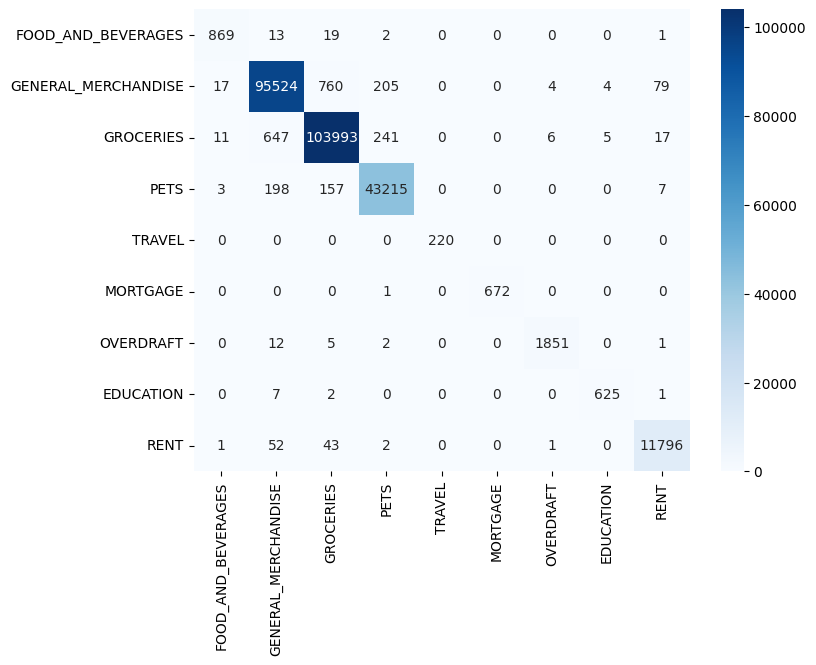

In [21]:
# getting the metric report to evaluate our model performance
pred_test = pl.predict(X_test)
print('Classification report: \n', classification_report(y_test, pred_test))
conf_mat = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=dff['category'].unique(), yticklabels=dff['category'].unique())
